In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import os

# Load datasets separately
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

# Label them
fake_df['label'] = 0  # Fake = 0
true_df['label'] = 1  # True = 1

# Combine title and text into 'content'
fake_df['content'] = fake_df['title'] + " " + fake_df['text']
true_df['content'] = true_df['title'] + " " + true_df['text']

# Clean function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)          # remove links
    text = re.sub(r"[^a-zA-Z]", " ", text)       # remove special chars
    text = text.lower()                          # lowercase
    return text

# Apply cleaning
fake_df['content'] = fake_df['content'].apply(clean_text)
true_df['content'] = true_df['content'].apply(clean_text)

# Split each into train/test (80:20)
fake_train, fake_test = train_test_split(fake_df[['content', 'label']], test_size=0.2, random_state=42, stratify=fake_df['label'])
true_train, true_test = train_test_split(true_df[['content', 'label']], test_size=0.2, random_state=42, stratify=true_df['label'])

# Save them to /kaggle/working
fake_train.to_csv('/kaggle/working/fake_train.csv', index=False)
fake_test.to_csv('/kaggle/working/fake_test.csv', index=False)
true_train.to_csv('/kaggle/working/true_train.csv', index=False)
true_test.to_csv('/kaggle/working/true_test.csv', index=False)

print("✅ Files saved to /kaggle/working/:")
print("- fake_train.csv")
print("- fake_test.csv")
print("- true_train.csv")
print("- true_test.csv")


✅ Files saved to /kaggle/working/:
- fake_train.csv
- fake_test.csv
- true_train.csv
- true_test.csv


✅ Accuracy: 0.9866
✅ Precision: 0.9835
✅ ROC AUC: 0.9987

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4697
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8981
   macro avg       0.99      0.99      0.99      8981
weighted avg       0.99      0.99      0.99      8981



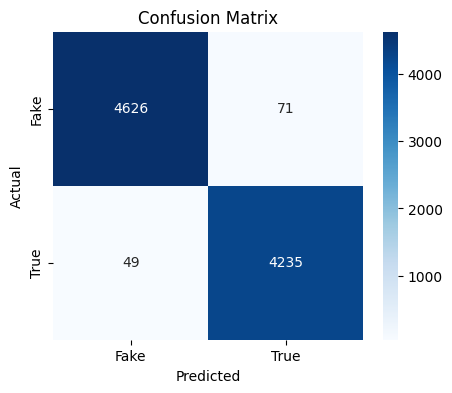

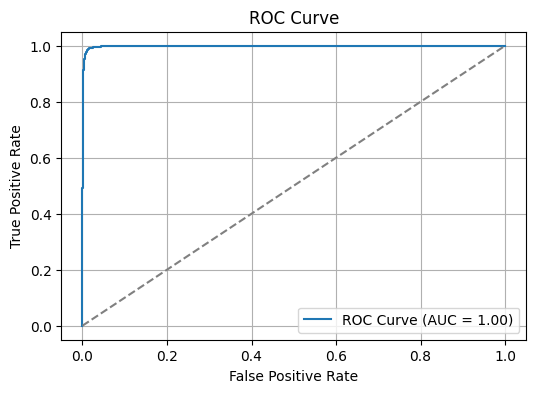

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, confusion_matrix, 
                             classification_report, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

# Load split data
fake_train = pd.read_csv('/kaggle/working/fake_train.csv')
fake_test = pd.read_csv('/kaggle/working/fake_test.csv')
true_train = pd.read_csv('/kaggle/working/true_train.csv')
true_test = pd.read_csv('/kaggle/working/true_test.csv')

# Combine fake and true train/test data
train_df = pd.concat([fake_train, true_train], ignore_index=True).sample(frac=1, random_state=42)
test_df = pd.concat([fake_test, true_test], ignore_index=True).sample(frac=1, random_state=42)

# Features and labels
X_train = train_df['content']
y_train = train_df['label']
X_test = test_df['content']
y_test = test_df['label']

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predict
y_pred = model.predict(X_test_tfidf)
y_proba = model.predict_proba(X_test_tfidf)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
